In [72]:
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import urllib.request
from urllib.request import urlopen
import requests
import re
import os

**to not limit the number of visible rows and columns**

In [245]:
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

**getting the latitudes and longitude of all neighborhoods in chennai**

In [8]:
url='https://chennaiiq.com/chennai/latitude_longitude_areas.asp'
page=requests.get(url)
soup=BeautifulSoup(page.text,'html.parser')
tables=soup.find_all('table',{'class':'TBox'})
tables

[<table align="center" border="0" cellpadding="3" cellspacing="1" class="TBox" width="70%">
 <tr class="tabH">
 <td colspan="4">List of Chennai City Latitude Longitude (Madras)</td>
 </tr>
 <tr class="tabH1">
 <td>S.No.</td>
 <td>Location</td>
 <td>Latitude</td>
 <td>Longitude</td>
 </tr>
 <tr class="tab"><td align="right">1</td><td> Adyar Bus Debot.</td><td> 12°59'50" N</td><td> 80°15'25" E</td></tr><tr class="tab"><td align="right">2</td><td> Adyar Signal</td><td> 13°00'23" N</td><td> 80°15'27" E</td></tr><tr class="tab"><td align="right">3</td><td> Alandur</td><td> 13°00'28" N</td><td> 80°12'35" E</td></tr><tr class="tab"><td align="right">4</td><td> Ambattur</td><td> 13°06'36" N</td><td> 80°10'12" E</td></tr><tr class="tab"><td align="right">5</td><td> Anna Arch</td><td> 13°04'28" N</td><td> 80°13'06" E</td></tr><tr class="tab"><td align="right">6</td><td> Anna Nagar Roundana</td><td> 13°05'04" N</td><td> 80°13'05" E</td></tr><tr class="tab"><td align="right">7</td><td> Anna Nagar 

**Getting the information into a dataframe**

In [28]:
latitude=[]
Neighborhood=[]
longitude=[]
for table in tables:
    rows=table.find_all('tr')
    for row in rows:
        cells=row.find_all('td')
        if(len(cells)>1):
            location=cells[1]
            Neighborhood.append(location.text.strip())
                
            lat=cells[2]
            latitude.append(lat.text.strip())
                
            long=cells[3]
            longitude.append(long.text.strip())

In [29]:
df=pd.DataFrame(Neighborhood,columns=['Neighborhood'])
df['latitude']=latitude
df['longitude']=longitude
df.head()

Neighborhood     latitude    longitude
0          Location     Latitude    Longitude
1  Adyar Bus Debot.  12°59'50" N  80°15'25" E
2      Adyar Signal  13°00'23" N  80°15'27" E
3           Alandur  13°00'28" N  80°12'35" E
4          Ambattur  13°06'36" N  80°10'12" E

In [30]:
df.shape

(106, 3)

In [31]:
df.drop(0,axis=0,inplace=True)
df.head()

Neighborhood     latitude    longitude
1  Adyar Bus Debot.  12°59'50" N  80°15'25" E
2      Adyar Signal  13°00'23" N  80°15'27" E
3           Alandur  13°00'28" N  80°12'35" E
4          Ambattur  13°06'36" N  80°10'12" E
5         Anna Arch  13°04'28" N  80°13'06" E

In [32]:
df.shape

(105, 3)

**Perform string operation to convert the location data from dms(degrees minutes seconds) to decimals**

In [33]:
def dms_to_dec_latlng(lat,long):
    min_pat=re.compile(r'[°](\d{2})[\']')
    sec_pat=re.compile(r'[\'](\d{2})[\"]')
    minutes_lat=(float(min_pat.search(lat).group(1)))/60
    seconds_lat=(float(sec_pat.search(lat).group(1)))/3600
    minutes_long=(float(min_pat.search(long).group(1)))/60
    seconds_long=(float(sec_pat.search(long).group(1)))/3600
    dec_lat=minutes_lat+seconds_lat
    dec_long=minutes_long+seconds_long
    pattern_south=re.compile(r'S$')
    pattern_west=re.compile(r'W$')
    south=pattern_south.search(lat)
    west=pattern_west.search(long)
    if (south==None):
        if (west==None):
            return [(float(lat[0:2])+dec_lat),(float(long[0:2])+dec_long)]
        else:
            return [(float(lat[0:2])+dec_lat),((float(long[0:2])+dec_long))*(-1)]
    else:
        if(west==None):
            return [((float(lat[0:2])+dec_lat))*(-1),(float(long[0:2])+dec_long)]
        else:
            return [((float(lat[0:2])+dec_lat))*(-1),((float(long[0:2])+dec_long))*(-1)]  

In [35]:
for index in range(1,(df.shape[0]+1)):
    lat=df.loc[index,'latitude']
    lng=df.loc[index,'longitude']
    fixed_loc=dms_to_dec_latlng(lat,lng)
    df.at[index,'latitude']=fixed_loc[0]
    df.at[index,'longitude']=fixed_loc[1]

In [50]:
df.head(105)

Neighborhood latitude longitude
1                          Adyar Bus Debot.  12.9972   80.2569
2                              Adyar Signal  13.0064   80.2575
3                                   Alandur  13.0078   80.2097
4                                  Ambattur    13.11     80.17
5                                 Anna Arch  13.0744   80.2183
6                       Anna Nagar Roundana  13.0844   80.2181
7                  Anna Nagar West Terminus  13.0931   80.1986
8                               Anna Statue  13.0681   80.2719
9                  Anna University Entrance  13.0081    80.235
10                                    Avadi  13.1203     80.11
11                               AVM Studio  13.0478    80.205
12                           Ayyappa Temple  13.0564   80.2317
13                             Basin Bridge  13.1022   80.2714
14                          Chennai Airport  12.9922   80.1694
15                          Chennai Central  13.0822   80.2756
16     Chennai Mofussil Bus Terminas (CMBT)  13.0678   80.2058
17                     Chennai Trade Center  13.0147   80.1911
18                        Chepaukam Stadium  13.0642   80.2664
19                                  chetput  13.0733   80.2428
20                             Chintadripet  13.0717   80.2739
21                        Chintamani Signal   13.085   80.2242
22                                    Chola  13.0442   80.2597
23                              Church Park  13.0539   80.2544
24                                    CIPET  13.0142   80.2047
25                       CIT Nagar Roundana  13.0311   80.2372
26                                     CLRI  13.0078   80.2425
27                                      DPI  13.0681   80.2486
28                   Egmore Railway Station  13.0778   80.2617
29                          Ethiraj College  13.0636   80.2572
30                           Gemini Flyover  13.0522   80.2511
31                              Greams Road  13.0564    80.255
32                       Guindy Race Course  13.0047   80.2169
33                   Guindy Railway Station  13.0083   80.2125
34                               HTL Colony  13.0181   80.2078
35                               IIT Madras  13.0053   80.2419
36                       Indra Nagar, Adyar  12.9989   80.2514
37                                  Isphani   13.055   80.2497
38                        Kamarajar Arangam  13.0489   80.2481
39                     Kapaleeswarar Temple  13.0528   80.2733
40                  Kasi Viswanathar Temple  13.0361   80.2247
41                   Kasturiba Nagar, Adyar  13.0033   80.2478
42                       Kathipara Junction  13.0072   80.2039
43                              Kodampakkam  13.0522   80.2311
44                               Korukkupet  13.1172   80.2778
45              Koyambedu Omni Bus Terminus  13.0683   80.1983
46                   Koyambedu Super Market  13.0675   80.1939
47                              Le Meridian  13.0067   80.2053
48                              Light House  13.0439   80.2772
49                           Loyolo College  13.0636   80.2347
50                               Madhavaram    13.02     80.26
51                           Madhya Kailash  13.0064   80.2469
52                                 Mambalam  13.0389   80.2286
53                                   Manali  13.1514   80.2503
54                              Minambakkam  12.9847   80.1778
55                            MIOT Hospital  13.0203   80.1847
56                             MMM Hospital  13.0861   80.1875
57                                     MRTS  12.9672     80.22
58                  Mugappair East Terminus  13.0803   80.1806
59                           Mugappair West  13.0819   80.1703
60                            Music Academy  13.0458   80.2594
61                          Nandanam Signal  13.0311     80.24
62                              Nanganallur  12.9917   80.1967
63                       Nehru Nagar, Adyar  13.0022   80.2517

In [38]:
df=df.astype({'latitude':'float64','longitude':'float64'})

Neighborhood   latitude  longitude
1          Adyar Bus Debot.  12.997222  80.256944
2              Adyar Signal  13.006389  80.257500
3                   Alandur  13.007778  80.209722
4                  Ambattur  13.110000  80.170000
5                 Anna Arch  13.074444  80.218333
..                      ...        ...        ...
101  Velachery Bus Terminus  12.975833  80.220833
102             Villivakkam  13.110000  80.203333
103             Vyasar Padi  13.109167  80.262500
104            Washermanpet  13.108611  80.281111
105      Woodlands Drive In  13.050000  80.251111

[105 rows x 3 columns]

In [39]:
from geopy.geocoders import Nominatim
import folium

In [40]:
address='Chennai, Tamil Nadu, India'
geolocator = Nominatim(user_agent="chennai_explorer")
location = geolocator.geocode(address)
ch_lat = location.latitude
ch_lng = location.longitude
print(ch_lat,ch_lng)

13.0801721 80.2838331


**Plot a map centered on Chennai and showing the different neighborhoods**

In [41]:
chennai_map=folium.Map([ch_lat,ch_lng],zoom_start=11)
folium.CircleMarker([ch_lat,ch_lng],radius=12,popup='Chennai',fill=True,fill_color='#FF2D00',fill_opacity=0.8).add_to(chennai_map)

for lat,lng,neigh in zip(df.latitude,df.longitude,df.Neighborhood):
    folium.CircleMarker([lat,lng],radius=6,popup=neigh,fill=True,fill_color='#0032FF',fill_opacity=0.7).add_to(chennai_map)
chennai_map

In [43]:
CLIENT_ID = 'GIL5KFTBUZBWMUCEWGMC1NISL2E1BFTEWROCHKPEJDBQVU2M' 
CLIENT_SECRET = 'TBEJZQQAZ4SCSEZ2WZIJ2GPTOMO4C1ZQ4FI5OC5YBSJKT450'
VERSION = '20200404' 
radius=1000
LIMIT=100

**Testing Foursquare explore? and categories?**

In [46]:
url_categories = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, ch_lat, ch_lng, radius, LIMIT)
print(url)

https://api.foursquare.com/v2/venues/explore?&client_id=GIL5KFTBUZBWMUCEWGMC1NISL2E1BFTEWROCHKPEJDBQVU2M&client_secret=TBEJZQQAZ4SCSEZ2WZIJ2GPTOMO4C1ZQ4FI5OC5YBSJKT450&v=20200404&ll=13.0801721,80.2838331&radius=1000&limit=100


In [45]:
result=requests.get(url).json()
result

{'meta': {'code': 200, 'requestId': '5e9bfd899388d7002442f383'},
 'response': {'categories': [{'id': '4d4b7104d754a06370d81259',
    'name': 'Arts & Entertainment',
    'pluralName': 'Arts & Entertainment',
    'shortName': 'Arts & Entertainment',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_',
     'suffix': '.png'},
    'categories': [{'id': '56aa371be4b08b9a8d5734db',
      'name': 'Amphitheater',
      'pluralName': 'Amphitheaters',
      'shortName': 'Amphitheater',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_',
       'suffix': '.png'},
      'categories': []},
     {'id': '4fceea171983d5d06c3e9823',
      'name': 'Aquarium',
      'pluralName': 'Aquariums',
      'shortName': 'Aquarium',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/aquarium_',
       'suffix': '.png'},
      'categories': []},
     {'id': '4bf58dd8d48988d1e1931735',
      'name': 'A

In [55]:
url_explore = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, ch_lat, ch_lng, radius, LIMIT)
result=requests.get(url).json()
result

{'meta': {'code': 200, 'requestId': '5e9c424d618f43001b71dc54'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Chennai',
  'headerFullLocation': 'Chennai',
  'headerLocationGranularity': 'city',
  'totalResults': 10,
  'suggestedBounds': {'ne': {'lat': 13.089172109000009,
    'lng': 80.29305558846286},
   'sw': {'lat': 13.071172090999992, 'lng': 80.27461061153713}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4cb9863b90c9a143bac487d6',
       'name': 'Fort Museum',
       'location': {'lat': 13.080618432998454,
        'lng': 80.2877188704723,
        'labeledLatLngs': [{'label': 'display',
          'lat': 13.080618432998454,
          'lng': 80.2877188704723}],
        'dis

**Getting all the venues in all the neighborhoods in chennai**

In [76]:
def get_nearby_venues(names,latitude,longitude,radius=1000):
    venues_list=[]
    LIMIT=100
    for name,lat,lng in zip(names,latitude,longitude):
        url='https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
        result=requests.get(url).json()['response']['groups'][0]['items']
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in result])
    
    nearby_venues=pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns=['Neighborhood','Area Latitude','Area Longitude','Venue Name','Venue Latitude','Venue Longitude','Venue Category']
    return (nearby_venues)

In [77]:
chennai_venues=get_nearby_venues(df.Neighborhood,df.latitude,df.longitude)
chennai_venues

Neighborhood  Area Latitude  Area Longitude  \
0                           Adyar Bus Debot.      12.997222       80.256944   
1                           Adyar Bus Debot.      12.997222       80.256944   
2                           Adyar Bus Debot.      12.997222       80.256944   
3                           Adyar Bus Debot.      12.997222       80.256944   
4                           Adyar Bus Debot.      12.997222       80.256944   
5                           Adyar Bus Debot.      12.997222       80.256944   
6                           Adyar Bus Debot.      12.997222       80.256944   
7                           Adyar Bus Debot.      12.997222       80.256944   
8                           Adyar Bus Debot.      12.997222       80.256944   
9                           Adyar Bus Debot.      12.997222       80.256944   
10                          Adyar Bus Debot.      12.997222       80.256944   
11                          Adyar Bus Debot.      12.997222       80.256944   
12                          Adyar Bus Debot.      12.997222       80.256944   
13                          Adyar Bus Debot.      12.997222       80.256944   
14                          Adyar Bus Debot.      12.997222       80.256944   
15                          Adyar Bus Debot.      12.997222       80.256944   
16                          Adyar Bus Debot.      12.997222       80.256944   
17                          Adyar Bus Debot.      12.997222       80.256944   
18                          Adyar Bus Debot.      12.997222       80.256944   
19                          Adyar Bus Debot.      12.997222       80.256944   
20                          Adyar Bus Debot.      12.997222       80.256944   
21                          Adyar Bus Debot.      12.997222       80.256944   
22                          Adyar Bus Debot.      12.997222       80.256944   
23                          Adyar Bus Debot.      12.997222       80.256944   
24                          Adyar Bus Debot.      12.997222       80.256944   
25                          Adyar Bus Debot.      12.997222       80.256944   
26                          Adyar Bus Debot.      12.997222       80.256944   
27                          Adyar Bus Debot.      12.997222       80.256944   
28                          Adyar Bus Debot.      12.997222       80.256944   
29                          Adyar Bus Debot.      12.997222       80.256944   
30                          Adyar Bus Debot.      12.997222       80.256944   
31                          Adyar Bus Debot.      12.997222       80.256944   
32                          Adyar Bus Debot.      12.997222       80.256944   
33                          Adyar Bus Debot.      12.997222       80.256944   
34                          Adyar Bus Debot.      12.997222       80.256944   
35                          Adyar Bus Debot.      12.997222       80.256944   
36                          Adyar Bus Debot.      12.997222       80.256944   
37                          Adyar Bus Debot.      12.997222       80.256944   
38                          Adyar Bus Debot.      12.997222       80.256944   
39                              Adyar Signal      13.006389       80.257500   
40                              Adyar Signal      13.006389       80.257500   
41                              Adyar Signal      13.006389       80.257500   
42                              Adyar Signal      13.006389       80.257500   
43                              Adyar Signal      13.006389       80.257500   
44                              Adyar Signal      13.006389       80.257500   
45                              Adyar Signal      13.006389       80.257500   
46                              Adyar Signal      13.006389       80.257500   
47                              Adyar Signal      13.006389       80.257500   
48                              Adyar Signal      13.006389       80.257500   
49                              Adyar Signal      13.006389       80.257500   
50 

**Since foursquare api has a limited number of calls, put the venues into a csv file to prevent calling it again later**

In [78]:
chennai_venues.to_csv("chennai_venues.csv", header=True, index=False, encoding="utf-8")

In [150]:
chennai_venues=pd.read_csv('/Users/Karthik/Desktop/Python folder/chennai_venues.csv')
chennai_venues

Neighborhood  Area Latitude  Area Longitude  \
0                           Adyar Bus Debot.      12.997222       80.256944   
1                           Adyar Bus Debot.      12.997222       80.256944   
2                           Adyar Bus Debot.      12.997222       80.256944   
3                           Adyar Bus Debot.      12.997222       80.256944   
4                           Adyar Bus Debot.      12.997222       80.256944   
5                           Adyar Bus Debot.      12.997222       80.256944   
6                           Adyar Bus Debot.      12.997222       80.256944   
7                           Adyar Bus Debot.      12.997222       80.256944   
8                           Adyar Bus Debot.      12.997222       80.256944   
9                           Adyar Bus Debot.      12.997222       80.256944   
10                          Adyar Bus Debot.      12.997222       80.256944   
11                          Adyar Bus Debot.      12.997222       80.256944   
12                          Adyar Bus Debot.      12.997222       80.256944   
13                          Adyar Bus Debot.      12.997222       80.256944   
14                          Adyar Bus Debot.      12.997222       80.256944   
15                          Adyar Bus Debot.      12.997222       80.256944   
16                          Adyar Bus Debot.      12.997222       80.256944   
17                          Adyar Bus Debot.      12.997222       80.256944   
18                          Adyar Bus Debot.      12.997222       80.256944   
19                          Adyar Bus Debot.      12.997222       80.256944   
20                          Adyar Bus Debot.      12.997222       80.256944   
21                          Adyar Bus Debot.      12.997222       80.256944   
22                          Adyar Bus Debot.      12.997222       80.256944   
23                          Adyar Bus Debot.      12.997222       80.256944   
24                          Adyar Bus Debot.      12.997222       80.256944   
25                          Adyar Bus Debot.      12.997222       80.256944   
26                          Adyar Bus Debot.      12.997222       80.256944   
27                          Adyar Bus Debot.      12.997222       80.256944   
28                          Adyar Bus Debot.      12.997222       80.256944   
29                          Adyar Bus Debot.      12.997222       80.256944   
30                          Adyar Bus Debot.      12.997222       80.256944   
31                          Adyar Bus Debot.      12.997222       80.256944   
32                          Adyar Bus Debot.      12.997222       80.256944   
33                          Adyar Bus Debot.      12.997222       80.256944   
34                          Adyar Bus Debot.      12.997222       80.256944   
35                          Adyar Bus Debot.      12.997222       80.256944   
36                          Adyar Bus Debot.      12.997222       80.256944   
37                          Adyar Bus Debot.      12.997222       80.256944   
38                          Adyar Bus Debot.      12.997222       80.256944   
39                              Adyar Signal      13.006389       80.257500   
40                              Adyar Signal      13.006389       80.257500   
41                              Adyar Signal      13.006389       80.257500   
42                              Adyar Signal      13.006389       80.257500   
43                              Adyar Signal      13.006389       80.257500   
44                              Adyar Signal      13.006389       80.257500   
45                              Adyar Signal      13.006389       80.257500   
46                              Adyar Signal      13.006389       80.257500   
47                              Adyar Signal      13.006389       80.257500   
48                              Adyar Signal      13.006389       80.257500   
49                              Adyar Signal      13.006389       80.257500   
50 

**unique venue categories in chennai_venues**

In [151]:
venue_list=chennai_venues['Venue Category'].unique()
print(venue_list.shape[0])
venue_list

182


array(['Middle Eastern Restaurant', 'Asian Restaurant', 'Café',
       'Fruit & Vegetable Store', 'Pizza Place', 'Fast Food Restaurant',
       "Women's Store", 'Indian Restaurant', 'Chinese Restaurant',
       'Diner', 'Sandwich Place', 'Gym', 'BBQ Joint', 'Hotel',
       'Multiplex', 'Movie Theater', 'Arcade', 'Breakfast Spot',
       'Electronics Store', 'Hotel Bar', 'Juice Bar', 'Bakery',
       'Ice Cream Shop', 'Pharmacy', 'Shopping Mall',
       'North Indian Restaurant', 'Vegetarian / Vegan Restaurant',
       'Grocery Store', 'Bookstore', 'Dessert Shop', 'Rock Club',
       'Lounge', 'Snack Place', 'Mediterranean Restaurant',
       'Italian Restaurant', 'Coffee Shop', 'Department Store',
       'Comfort Food Restaurant', 'Furniture / Home Store',
       'Gourmet Shop', 'Bus Station', 'Bar', 'Pool Hall', 'Airport',
       'Golf Course', 'Cafeteria', 'Supermarket', 'Gas Station',
       'Clothing Store', 'South Indian Restaurant', 'Scenic Lookout',
       'Food', 'Sporting Good

**Extracting only the restaurants into a dataframe**

In [152]:
Neighborhood=[]
venue=[]
category=[]
venue_lat=[]
venue_lng=[]
for i in range(0,chennai_venues.shape[0]):
    cell=chennai_venues.loc[i,'Venue Category']
    a=cell.split(" ")
    results=[a[-1]=='Restaurant',
             a[-1]=='Place',
             a[-1]=='Joint',
             a[0]=='Cafe',
             a[0]=='Diner',
             a[0]=='Steakhouse',
             a[0]=='Buffet',
             a[0]=='Bistro',
             a[0]=='Cafeteria',
             a[0]=='Food',
             a[0]=='Breakfast',
             a[-1]=='Breakfast',
             a[0]=='Dessert',
             a[0]=='Coffee',
             a[0]=='Juice']
    if any(results):
        Neighborhood.append(chennai_venues.loc[i,'Neighborhood'])
        venue.append(chennai_venues.loc[i,'Venue Name'])
        category.append(chennai_venues.loc[i,'Venue Category'])
        venue_lat.append(chennai_venues.loc[i,'Venue Latitude'])
        venue_lng.append(chennai_venues.loc[i,'Venue Longitude'])

In [154]:
dataset={'Neighborhood':Neighborhood,'Venue Name':venue,'Venue Latitude':venue_lat,'Venue Longitude':venue_lng,'Venue Category':category}
chennai_restaurants=pd.DataFrame(data=dataset)
print(chennai_restaurants.shape)
chennai_restaurants

(1850, 5)


Neighborhood  \
0                           Adyar Bus Debot.   
1                           Adyar Bus Debot.   
2                           Adyar Bus Debot.   
3                           Adyar Bus Debot.   
4                           Adyar Bus Debot.   
5                           Adyar Bus Debot.   
6                           Adyar Bus Debot.   
7                           Adyar Bus Debot.   
8                           Adyar Bus Debot.   
9                           Adyar Bus Debot.   
10                          Adyar Bus Debot.   
11                          Adyar Bus Debot.   
12                          Adyar Bus Debot.   
13                          Adyar Bus Debot.   
14                          Adyar Bus Debot.   
15                          Adyar Bus Debot.   
16                          Adyar Bus Debot.   
17                          Adyar Bus Debot.   
18                          Adyar Bus Debot.   
19                          Adyar Bus Debot.   
20                          Adyar Bus Debot.   
21                          Adyar Bus Debot.   
22                          Adyar Bus Debot.   
23                              Adyar Signal   
24                              Adyar Signal   
25                              Adyar Signal   
26                              Adyar Signal   
27                              Adyar Signal   
28                              Adyar Signal   
29                              Adyar Signal   
30                              Adyar Signal   
31                              Adyar Signal   
32                              Adyar Signal   
33                              Adyar Signal   
34                              Adyar Signal   
35                              Adyar Signal   
36                              Adyar Signal   
37                              Adyar Signal   
38                              Adyar Signal   
39                              Adyar Signal   
40                              Adyar Signal   
41                              Adyar Signal   
42                              Adyar Signal   
43                              Adyar Signal   
44                              Adyar Signal   
45                              Adyar Signal   
46                              Adyar Signal   
47                              Adyar Signal   
48                              Adyar Signal   
49                              Adyar Signal   
50                              Adyar Signal   
51                              Adyar Signal   
52                              Adyar Signal   
53                              Adyar Signal   
54                              Adyar Signal   
55                              Adyar Signal   
56                              Adyar Signal   
57                              Adyar Signal   
58                              Adyar Signal   
59                              Adyar Signal   
60                              Adyar Signal   
61                              Adyar Signal   
62                                   Alandur   
63                                   Alandur   
64                                  Ambattur   
65                                 Anna Arch   
66                                 Anna Arch   
67                                 Anna Arch   
68                                 Anna Arch   
69                                 Anna Arch   
70                                 Anna Arch   
71                                 Anna Arch   
72                                 Anna Arch   
73                                 Anna Arch   
74                                 Anna Arch   
75                                 Anna Arch   
76                                 Anna Arch   
77                       Anna Nagar Roundana   
78                       Anna Nagar Roundana   
79                       Anna Nagar Roundana   
80                       Anna Nagar Roundana   
81                       Anna Nagar Roundana   
82                       Anna Nagar Roundana   


**Types and counts of the different venue categories**

In [155]:
restaurants=chennai_restaurants['Venue Category'].unique()
print(restaurants.shape[0])
restaurants

56


array(['Middle Eastern Restaurant', 'Asian Restaurant', 'Pizza Place',
       'Fast Food Restaurant', 'Indian Restaurant', 'Chinese Restaurant',
       'Diner', 'Sandwich Place', 'BBQ Joint', 'Breakfast Spot',
       'Juice Bar', 'North Indian Restaurant',
       'Vegetarian / Vegan Restaurant', 'Dessert Shop', 'Snack Place',
       'Mediterranean Restaurant', 'Italian Restaurant', 'Coffee Shop',
       'Comfort Food Restaurant', 'Cafeteria', 'South Indian Restaurant',
       'Food', 'Restaurant', 'Burger Joint', 'Bistro', 'Food Court',
       'Multicuisine Indian Restaurant', 'Korean Restaurant',
       'Rajasthani Restaurant', 'Steakhouse', 'Mexican Restaurant',
       'American Restaurant', 'Halal Restaurant', 'Bed & Breakfast',
       'African Restaurant', 'Kerala Restaurant', 'Thai Restaurant',
       'Buffet', 'Kebab Restaurant', 'Bengali Restaurant',
       'Japanese Curry Restaurant', 'Portuguese Restaurant',
       'Seafood Restaurant', 'Japanese Restaurant',
       'Molecular

In [156]:
restaurants=chennai_restaurants.groupby(['Venue Category']).count()
restaurants.drop(['Venue Name','Venue Latitude','Venue Longitude'],axis=1,inplace=True)
restaurants.sort_values(by='Neighborhood',ascending=False,inplace=True)
restaurants

Neighborhood
Venue Category                               
Indian Restaurant                         625
Chinese Restaurant                        115
Pizza Place                                92
Fast Food Restaurant                       84
Coffee Shop                                83
Restaurant                                 78
Sandwich Place                             70
Vegetarian / Vegan Restaurant              68
Italian Restaurant                         64
Asian Restaurant                           63
Juice Bar                                  63
Dessert Shop                               50
South Indian Restaurant                    47
Middle Eastern Restaurant                  46
BBQ Joint                                  33
Snack Place                                28
Thai Restaurant                            20
Breakfast Spot                             15
Food Court                                 14
Bistro                                     12
Burger Joint                               12
Buffet                                     10
Japanese Restaurant                        10
Kebab Restaurant                           10
Bengali Restaurant                          9
Mexican Restaurant                          9
Japanese Curry Restaurant                   9
Portuguese Restaurant                       9
African Restaurant                          8
Multicuisine Indian Restaurant              7
Mediterranean Restaurant                    7
Diner                                       7
Comfort Food Restaurant                     7
Cafeteria                                   7
North Indian Restaurant                     7
Seafood Restaurant                          5
Kerala Restaurant                           5
Steakhouse                                  5
Modern European Restaurant                  5
American Restaurant                         4
Rajasthani Restaurant                       3
Molecular Gastronomy Restaurant             3
Malay Restaurant                            3
Food & Drink Shop                           3
Hyderabadi Restaurant                       3
Korean Restaurant                           2
Russian Restaurant                          2
New American Restaurant                     1
Halal Restaurant                            1
Falafel Restaurant                          1
Food                                        1
Andhra Restaurant                           1
Food Truck                                  1
Bed & Breakfast                             1
Burrito Place                               1
Fried Chicken Joint                         1

**Splitting the data into one dataframe with High frequency categories and one with low frequency categories**

In [157]:
restaurants=restaurants.astype({'Neighborhood':'int64'})
restaurants.reset_index(inplace=True)

In [158]:
highfreq_rest=restaurants[restaurants['Neighborhood']>=10]
lowfreq_rest=restaurants[restaurants['Neighborhood']<10]

In [159]:
hfr=list(highfreq_rest['Venue Category'])
lfr=list(lowfreq_rest['Venue Category'])

In [170]:
chennai_rest_lowfreq=chennai_restaurants
for i in range(0,chennai_restaurants.shape[0]):
    cell=chennai_restaurants.loc[i,'Venue Category']
    for ele in hfr:
        if cell==ele:
            chennai_rest_lowfreq=chennai_rest_lowfreq.drop(i,axis=0)
            break

In [171]:
chennai_rest_lowfreq

Neighborhood                             Venue Name  \
6               Adyar Bus Debot.                  Grand Sweets & Snacks   
23                  Adyar Signal                       Bombay Brassiere   
28                  Adyar Signal                  Daawat The Kebab Shop   
36                  Adyar Signal                             Azzuri Bay   
42                  Adyar Signal                  Grand Sweets & Snacks   
49                  Adyar Signal                             Kozhi Idli   
63                       Alandur                     Namma Coffee Kadai   
70                     Anna Arch                       Sachin Ka Dhabba   
193         Chennai Trade Center                           Buhari Hotel   
206            Chepaukam Stadium                     North East Kitchen   
208            Chepaukam Stadium                               Rajdhani   
211            Chepaukam Stadium                          Kobe Sizzlers   
221            Chepaukam Stadium                            Vestin Park   
224            Chepaukam Stadium                                   Kefi   
225            Chepaukam Stadium                                   Dine   
227            Chepaukam Stadium                 Kalyan Bhavan Biriyani   
232                      chetput                         Hotel Crescent   
244                      chetput               Sarovar Hotels & Resorts   
280                        Chola                          TOVO infusion   
281                        Chola                                Nando's   
286                        Chola                           Ente Keralam   
293                        Chola                       Don Pepe Tex Mex   
327                  Church Park                     Sree Mithai Sweets   
330                  Church Park                                Nando's   
347                  Church Park                               Mamagoto   
360                  Church Park                       Don Pepe Tex Mex   
367                  Church Park                         Goa Portuguesa   
375                  Church Park                           Texas Fiesta   
382                        CIPET                     Namma Coffee Kadai   
411                          DPI                             The Marina   
415                          DPI                         Hotel Crescent   
429                          DPI                               Mamagoto   
448                          DPI                         Goa Portuguesa   
452                          DPI                       Fisherman's Fare   
464       Egmore Railway Station                            Sudha Hotel   
471              Ethiraj College                     North East Kitchen   
474              Ethiraj College                             The Marina   
493              Ethiraj College                               Mamagoto   
505              Ethiraj College                          Kobe Sizzlers   
509              Ethiraj College                            Vestin Park   
513              Ethiraj College                         Goa Portuguesa   
517              Ethiraj College                                   Dine   
518              Ethiraj College                                   Kefi   
521               Gemini Flyover                     Sree Mithai Sweets   
530               Gemini Flyover                                Nando's   
547               Gemini Flyover                               Mamagoto   
567               Gemini Flyover                         Goa Portuguesa   
583                  Greams Road                     Sree Mithai Sweets   
591                  Greams Road                               Mamagoto   
615                  Greams Road                         Goa Portuguesa   
621                  Greams Road                           Texas Fiesta   
627                  Greams Road                          Yoko Sizzlers   
634           Guindy Race Course             

In [172]:
chennai_rest_lowfreq.shape

(138, 5)

In [173]:
chennai_rest_lowfreq.reset_index(inplace=True)
chennai_rest_highfreq.reset_index(inplace=True)
chennai_restaurants.reset_index(inplace=True)

**To find the mutually disjoint sets of chennai_restaurants and the low_freq_restaurants**

In [174]:
chennai_rest_highfreq=pd.concat([chennai_restaurants,chennai_rest_lowfreq,chennai_rest_lowfreq]).drop_duplicates(keep=False)

In [175]:
chennai_rest_highfreq.reset_index(inplace=True)

In [176]:
chennai_restaurants.drop(['index'],axis=1,inplace=True)
chennai_rest_lowfreq.drop(['index'],axis=1,inplace=True)
chennai_rest_highfreq.drop(['level_0','index'],axis=1,inplace=True)

In [177]:
chennai_rest_highfreq

Neighborhood  \
0                           Adyar Bus Debot.   
1                           Adyar Bus Debot.   
2                           Adyar Bus Debot.   
3                           Adyar Bus Debot.   
4                           Adyar Bus Debot.   
5                           Adyar Bus Debot.   
6                           Adyar Bus Debot.   
7                           Adyar Bus Debot.   
8                           Adyar Bus Debot.   
9                           Adyar Bus Debot.   
10                          Adyar Bus Debot.   
11                          Adyar Bus Debot.   
12                          Adyar Bus Debot.   
13                          Adyar Bus Debot.   
14                          Adyar Bus Debot.   
15                          Adyar Bus Debot.   
16                          Adyar Bus Debot.   
17                          Adyar Bus Debot.   
18                          Adyar Bus Debot.   
19                          Adyar Bus Debot.   
20                          Adyar Bus Debot.   
21                          Adyar Bus Debot.   
22                              Adyar Signal   
23                              Adyar Signal   
24                              Adyar Signal   
25                              Adyar Signal   
26                              Adyar Signal   
27                              Adyar Signal   
28                              Adyar Signal   
29                              Adyar Signal   
30                              Adyar Signal   
31                              Adyar Signal   
32                              Adyar Signal   
33                              Adyar Signal   
34                              Adyar Signal   
35                              Adyar Signal   
36                              Adyar Signal   
37                              Adyar Signal   
38                              Adyar Signal   
39                              Adyar Signal   
40                              Adyar Signal   
41                              Adyar Signal   
42                              Adyar Signal   
43                              Adyar Signal   
44                              Adyar Signal   
45                              Adyar Signal   
46                              Adyar Signal   
47                              Adyar Signal   
48                              Adyar Signal   
49                              Adyar Signal   
50                              Adyar Signal   
51                              Adyar Signal   
52                              Adyar Signal   
53                              Adyar Signal   
54                              Adyar Signal   
55                              Adyar Signal   
56                                   Alandur   
57                                  Ambattur   
58                                 Anna Arch   
59                                 Anna Arch   
60                                 Anna Arch   
61                                 Anna Arch   
62                                 Anna Arch   
63                                 Anna Arch   
64                                 Anna Arch   
65                                 Anna Arch   
66                                 Anna Arch   
67                                 Anna Arch   
68                                 Anna Arch   
69                       Anna Nagar Roundana   
70                       Anna Nagar Roundana   
71                       Anna Nagar Roundana   
72                       Anna Nagar Roundana   
73                       Anna Nagar Roundana   
74                       Anna Nagar Roundana   
75                       Anna Nagar Roundana   
76                       Anna Nagar Roundana   
77                       Anna Nagar Roundana   
78                       Anna Nagar Roundana   
79                       Anna Nagar Roundana   
80                       Anna Nagar Roundana   
81                       Anna Nagar Roundana   
82                       Anna Nagar Roundana   


chennai_venues -> Different venues in chennai

chennai_restaurants -> Restaurants in chennai                               

restaurants -> Categories of diff restaurants and their count

chennai_rest_highfreq -> High frequency restaurant distribution

chennai_rest_lowfreq -> Low frequency restaurant distribution

In [188]:
def dummies(dataframe):
    final=pd.get_dummies(dataframe[['Venue Category']],prefix="",prefix_sep="")
    final['Neighborhood']=dataframe['Neighborhood']
    fixed_columns=[final.columns[-1]]+list(final.columns[:-1])
    final=final[fixed_columns]
    final=final.groupby(['Neighborhood']).mean()
    return final

In [189]:
hf_rest_onehot=dummies(chennai_rest_highfreq)
hf_rest_onehot

Asian Restaurant  BBQ Joint    Bistro  \
Neighborhood                                                                    
AVM Studio                                      0.095238   0.047619  0.000000   
Adyar Bus Debot.                                0.090909   0.045455  0.000000   
Adyar Signal                                    0.029412   0.000000  0.000000   
Alandur                                         0.000000   0.000000  0.000000   
Ambattur                                        0.000000   0.000000  0.000000   
Anna Arch                                       0.000000   0.090909  0.000000   
Anna Nagar Roundana                             0.025641   0.025641  0.025641   
Anna Nagar West Terminus                        0.000000   0.083333  0.000000   
Anna Statue                                     0.000000   0.000000  0.000000   
Anna University Entrance                        0.000000   0.000000  0.000000   
Avadi                                           0.000000   0.000000  0.000000   
Ayyappa Temple                                  0.125000   0.125000  0.000000   
Basin Bridge                                    0.000000   0.000000  0.000000   
CIPET                                           0.222222   0.000000  0.000000   
CIT Nagar Roundana                              0.062500   0.000000  0.000000   
CLRI                                            0.000000   0.000000  0.000000   
Chennai Airport                                 0.000000   0.000000  0.000000   
Chennai Central                                 0.000000   0.000000  0.000000   
Chennai Mofussil Bus Terminas (CMBT)            0.000000   0.000000  0.000000   
Chennai Trade Center                            0.000000   0.000000  0.000000   
Chepaukam Stadium                               0.000000   0.000000  0.000000   
Chintadripet                                    0.000000   0.000000  0.000000   
Chintamani Signal                               0.045455   0.000000  0.000000   
Chola                                           0.000000   0.000000  0.000000   
Church Park                                     0.040000   0.020000  0.020000   
DPI                                             0.073171   0.000000  0.000000   
Egmore Railway Station                          0.083333   0.000000  0.000000   
Ethiraj College                                 0.047619   0.000000  0.023810   
Gemini Flyover                                  0.040816   0.020408  0.020408   
Greams Road                                     0.039216   0.019608  0.019608   
Guindy Race Course                              0.111111   0.000000  0.000000   
Guindy Railway Station                          0.142857   0.000000  0.000000   
HTL Colony                                      0.222222   0.000000  0.000000   
IIT Madras                                      0.000000   0.000000  0.000000   
Indra Nagar, Adyar                              0.103448   0.034483  0.000000   
Isphani                                         0.037736   0.018868  0.018868   
Kamarajar Arangam                               0.027027   0.054054  0.000000   
Kapaleeswarar Temple                            0.000000   0.000000  0.000000   
Kasi Viswanathar Temple                         0.166667   0.000000  0.000000   
Kasturiba Nagar, Adyar                          0.045455   0.000000  0.000000   
Kathipara Junction                              0.000000   0.000000  0.000000   
Kodampakkam                                     0.083333   0.250000  0.000000   
Korukkupet                                      0.000000   0.000000  0.000000   
Koyambedu Omni Bus Terminus                     0.000000   0.000000  0.000000   
Le Meridian                                     0.000000   0.000000  0.000000   
Light House                                     0.000000   0.000000  0.000000   
Loyolo College                                  0.045455   0.000000  0.000000   
MIOT Hospital                                   0.000000   0.000000  0.

In [191]:
lf_rest_onehot=dummies(chennai_rest_lowfreq)
lf_rest_onehot

African Restaurant  American Restaurant  \
Neighborhood                                                          
Adyar Bus Debot.                      0.000000             0.000000   
Adyar Signal                          0.000000             0.000000   
Alandur                               0.000000             0.000000   
Anna Arch                             0.000000             0.000000   
CIPET                                 0.000000             0.000000   
Chennai Trade Center                  0.000000             0.000000   
Chepaukam Stadium                     0.000000             0.142857   
Chola                                 0.250000             0.000000   
Church Park                           0.166667             0.000000   
DPI                                   0.000000             0.000000   
Egmore Railway Station                0.000000             0.000000   
Ethiraj College                       0.000000             0.125000   
Gemini Flyover                        0.250000             0.000000   
Greams Road                           0.000000             0.000000   
Guindy Race Course                    0.000000             0.000000   
Guindy Railway Station                0.000000             0.000000   
HTL Colony                            0.000000             0.000000   
Indra Nagar, Adyar                    0.000000             0.000000   
Isphani                               0.000000             0.000000   
Kamarajar Arangam                     0.250000             0.000000   
Kapaleeswarar Temple                  0.000000             0.000000   
Kasturiba Nagar, Adyar                0.000000             0.000000   
Kathipara Junction                    0.000000             0.000000   
Le Meridian                           0.000000             0.000000   
Light House                           0.000000             0.500000   
Loyolo College                        0.000000             0.000000   
MIOT Hospital                         0.000000             0.000000   
MRTS                                  0.000000             0.000000   
Madhya Kailash                        0.000000             0.000000   
Manali                                0.000000             0.000000   
Mugappair West                        0.000000             0.000000   
Music Academy                         0.250000             0.000000   
Nanganallur                           0.000000             0.000000   
Nehru Nagar, Adyar                    0.000000             0.000000   
Panagal Park                          0.000000             0.000000   
Park Sheraton Hotel                   0.000000             0.000000   
Parthasarathy Temple                  0.000000             0.250000   
Saidapet Bus Terminus                 0.000000             0.000000   
Saidapet Court                        0.000000             0.000000   
Shastri Bhavan                        0.000000             0.000000   
St. Thomas Mount                      0.000000             0.000000   
Stella Maris                          0.250000             0.000000   
Taj Coromandal                        0.000000             0.000000   
Teynampet Signal                      0.000000             0.000000   
The US Consulate                      0.250000             0.000000   
Thirumangalam Signal                  0.000000             0.000000   
Triplicane                            0.000000             0.000000   
Triplicane Railway Station            0.000000             0.000000   
Vadapalani Signal                     0.000000             0.000000   
Valluvar Kottam                       0.000000             0.000000   
Vani Mahal                            0.000000             0.000000   
Velachery Bus Terminus                0.000000             0.000000   
Woodlands Drive In                    0.200000             0.000000   
chetput                               0.000000             0.000000   

                            Andhra Restaurant  Bed 

In [192]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [201]:
hf_rest_onehot.reset_index(inplace=True)
lf_rest_onehot.reset_index(inplace=True)

In [202]:
hf_clustering=hf_rest_onehot.drop('Neighborhood',1)
lf_clustering=lf_rest_onehot.drop('Neighborhood',1)

Asian Restaurant  BBQ Joint    Bistro  Breakfast Spot    Buffet  \
0            0.095238   0.047619  0.000000        0.000000  0.000000   
1            0.090909   0.045455  0.000000        0.045455  0.000000   
2            0.029412   0.000000  0.000000        0.000000  0.000000   
3            0.000000   0.000000  0.000000        0.000000  0.000000   
4            0.000000   0.000000  0.000000        0.000000  0.000000   
5            0.000000   0.090909  0.000000        0.000000  0.000000   
6            0.025641   0.025641  0.025641        0.000000  0.000000   
7            0.000000   0.083333  0.000000        0.000000  0.000000   
8            0.000000   0.000000  0.000000        0.000000  0.000000   
9            0.000000   0.000000  0.000000        0.000000  0.000000   
10           0.000000   0.000000  0.000000        0.000000  0.000000   
11           0.125000   0.125000  0.000000        0.000000  0.000000   
12           0.000000   0.000000  0.000000        0.000000  0.000000   
13           0.222222   0.000000  0.000000        0.000000  0.000000   
14           0.062500   0.000000  0.000000        0.000000  0.000000   
15           0.000000   0.000000  0.000000        0.000000  0.000000   
16           0.000000   0.000000  0.000000        0.000000  0.000000   
17           0.000000   0.000000  0.000000        0.000000  0.000000   
18           0.000000   0.000000  0.000000        0.000000  0.000000   
19           0.000000   0.000000  0.000000        0.000000  0.000000   
20           0.000000   0.000000  0.000000        0.040000  0.000000   
21           0.000000   0.000000  0.000000        0.000000  0.000000   
22           0.045455   0.000000  0.000000        0.000000  0.000000   
23           0.000000   0.000000  0.000000        0.000000  0.027778   
24           0.040000   0.020000  0.020000        0.000000  0.020000   
25           0.073171   0.000000  0.000000        0.000000  0.024390   
26           0.083333   0.000000  0.000000        0.000000  0.000000   
27           0.047619   0.000000  0.023810        0.023810  0.023810   
28           0.040816   0.020408  0.020408        0.000000  0.020408   
29           0.039216   0.019608  0.019608        0.000000  0.019608   
30           0.111111   0.000000  0.000000        0.000000  0.000000   
31           0.142857   0.000000  0.000000        0.000000  0.000000   
32           0.222222   0.000000  0.000000        0.000000  0.000000   
33           0.000000   0.000000  0.000000        0.000000  0.000000   
34           0.103448   0.034483  0.000000        0.034483  0.000000   
35           0.037736   0.018868  0.018868        0.000000  0.018868   
36           0.027027   0.054054  0.000000        0.000000  0.000000   
37           0.000000   0.000000  0.000000        0.000000  0.000000   
38           0.166667   0.000000  0.000000        0.000000  0.000000   
39           0.045455   0.000000  0.000000        0.045455  0.000000   
40           0.000000   0.000000  0.000000        0.142857  0.000000   
41           0.083333   0.250000  0.000000        0.000000  0.000000   
42           0.000000   0.000000  0.000000        0.000000  0.000000   
43           0.000000   0.000000  0.000000        0.000000  0.000000   
44           0.000000   0.000000  0.000000        0.166667  0.000000   
45           0.000000   0.000000  0.000000        0.000000  0.000000   
46           0.045455   0.000000  0.000000        0.000000  0.000000   
47           0.000000   0.000000  0.000000        0.000000  0.000000   
48           0.000000   0.000000  0.000000        0.000000  0.000000   
49           0.000000   0.000000  0.000000        0.000000  0.000000   
50           0.000000   0.000000  0.000000        0.000000  0.000000   
51           0.045455   0.000000  0.000000        0.000000  0.000000   
52           0.052632   0.052632  0.000000        0.000000  0.000000   
53           0.000000   0.000000  0.000000        0.000000  0.000000   
54           0.000000   0.000000  0.000000   

In [209]:
sse_hf={}
sse_lf={}
for k in range(1,20):
    kmeans_hf=KMeans(n_clusters=k).fit(hf_clustering)
    kmeans_lf=KMeans(n_clusters=k).fit(lf_clustering)
    sse_hf[k]=kmeans_hf.inertia_
    sse_lf[k]=kmeans_lf.inertia_

**k=7 is the elbow point for the high frequency data**

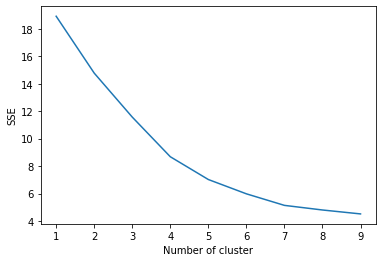

In [207]:
plt.figure()
plt.plot(list(sse_hf.keys()), list(sse_hf.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

**around k=15 seems to be the elbow point here**

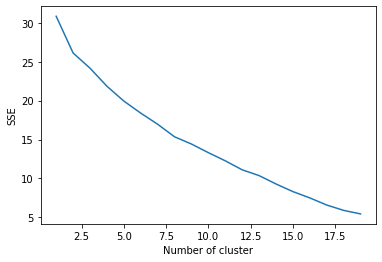

In [210]:
plt.figure()
plt.plot(list(sse_lf.keys()), list(sse_lf.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [211]:
k_hf=7
k_lf=15
kmeans_hf=KMeans(n_clusters=k_hf).fit(hf_clustering)
kmeans_lf=KMeans(n_clusters=k_lf).fit(lf_clustering)

In [222]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [218]:
nnp.

25

In [231]:
def column_names(num_top_venues):
    indicators = ['st', 'nd', 'rd']
    columns = ['Neighborhood']
    for ind in np.arange(num_top_venues-1):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))
    
    return columns
            
hf_rest_sorted=pd.DataFrame(columns=column_names(hf_rest_onehot.shape[1]))
lf_rest_sorted=pd.DataFrame(columns=column_names(lf_rest_onehot.shape[1]))

hf_rest_sorted['Neighborhood']=hf_rest_onehot['Neighborhood']
lf_rest_sorted['Neighborhood']=lf_rest_onehot['Neighborhood']

for ind in np.arange(hf_rest_onehot.shape[0]):
    hf_rest_sorted.iloc[ind, 1:] = return_most_common_venues(hf_rest_onehot.iloc[ind, :], hf_rest_onehot.shape[1])
                            
for ind in np.arange(lf_rest_onehot.shape[0]):
    lf_rest_sorted.iloc[ind, 1:] = return_most_common_venues(lf_rest_onehot.iloc[ind, :], lf_rest_onehot.shape[1])

In [232]:
hf_rest_sorted.insert(1,'Cluster Labels',kmeans_hf.labels_)
lf_rest_sorted.insert(1,'Cluster Labels',kmeans_lf.labels_)

In [233]:
hf_rest_sorted

Neighborhood  Cluster Labels  \
0                                AVM Studio               1   
1                          Adyar Bus Debot.               1   
2                              Adyar Signal               1   
3                                   Alandur               4   
4                                  Ambattur               6   
5                                 Anna Arch               3   
6                       Anna Nagar Roundana               3   
7                  Anna Nagar West Terminus               1   
8                               Anna Statue               4   
9                  Anna University Entrance               3   
10                                    Avadi               4   
11                           Ayyappa Temple               3   
12                             Basin Bridge               6   
13                                    CIPET               1   
14                       CIT Nagar Roundana               1   
15                                     CLRI               1   
16                          Chennai Airport               0   
17                          Chennai Central               1   
18     Chennai Mofussil Bus Terminas (CMBT)               0   
19                     Chennai Trade Center               3   
20                        Chepaukam Stadium               1   
21                             Chintadripet               4   
22                        Chintamani Signal               1   
23                                    Chola               1   
24                              Church Park               1   
25                                      DPI               1   
26                   Egmore Railway Station               1   
27                          Ethiraj College               3   
28                           Gemini Flyover               3   
29                              Greams Road               3   
30                       Guindy Race Course               1   
31                   Guindy Railway Station               1   
32                               HTL Colony               1   
33                               IIT Madras               1   
34                       Indra Nagar, Adyar               1   
35                                  Isphani               3   
36                        Kamarajar Arangam               1   
37                     Kapaleeswarar Temple               1   
38                  Kasi Viswanathar Temple               3   
39                   Kasturiba Nagar, Adyar               1   
40                       Kathipara Junction               4   
41                              Kodampakkam               3   
42                               Korukkupet               5   
43              Koyambedu Omni Bus Terminus               0   
44                              Le Meridian               4   
45                              Light House               0   
46                           Loyolo College               3   
47                            MIOT Hospital               0   
48                             MMM Hospital               3   
49                                     MRTS               1   
50                               Madhavaram               3   
51                           Madhya Kailash               1   
52                                 Mambalam               3   
53                              Minambakkam               0   
54                  Mugappair East Terminus               4   
55                           Mugappair West               3   
56                            Music Academy               1   
57                          Nandanam Signal               3   
58                              Nanganallur               3   
59                       Nehru Nagar, Adyar               1   
60                 Newaharlal Nehru Stadium               1   
61             Nungampakkam Railway Station               3   
62                             Panagal Park               1   

In [234]:
lf_rest_sorted

Neighborhood  Cluster Labels  \
0             Adyar Bus Debot.               3   
1                 Adyar Signal               7   
2                      Alandur               2   
3                    Anna Arch              10   
4                        CIPET               2   
5         Chennai Trade Center               6   
6            Chepaukam Stadium              13   
7                        Chola               1   
8                  Church Park               1   
9                          DPI               1   
10      Egmore Railway Station               3   
11             Ethiraj College               1   
12              Gemini Flyover               1   
13                 Greams Road               1   
14          Guindy Race Course              11   
15      Guindy Railway Station               2   
16                  HTL Colony               2   
17          Indra Nagar, Adyar               7   
18                     Isphani               1   
19           Kamarajar Arangam               1   
20        Kapaleeswarar Temple               3   
21      Kasturiba Nagar, Adyar               7   
22          Kathipara Junction               2   
23                 Le Meridian               2   
24                 Light House               3   
25              Loyolo College               2   
26               MIOT Hospital              13   
27                        MRTS               4   
28              Madhya Kailash               7   
29                      Manali              14   
30              Mugappair West               0   
31               Music Academy               1   
32                 Nanganallur              12   
33          Nehru Nagar, Adyar               7   
34                Panagal Park               5   
35         Park Sheraton Hotel               5   
36        Parthasarathy Temple              13   
37       Saidapet Bus Terminus               0   
38              Saidapet Court               0   
39              Shastri Bhavan               1   
40            St. Thomas Mount               6   
41                Stella Maris               1   
42              Taj Coromandal               1   
43            Teynampet Signal               5   
44            The US Consulate               1   
45        Thirumangalam Signal               8   
46                  Triplicane               5   
47  Triplicane Railway Station              13   
48           Vadapalani Signal               9   
49             Valluvar Kottam               5   
50                  Vani Mahal               5   
51      Velachery Bus Terminus               4   
52          Woodlands Drive In               1   
53                     chetput               6   

              1st Most Common Venue            2nd Most Common Venue  \
0                             Diner                       Steakhouse   
1           North Indian Restaurant          Comfort Food Restaurant   
2                         Cafeteria                       Steakhouse   
3                              Food                       Steakhouse   
4                         Cafeteria                       Steakhouse   
5    Multicuisine Indian Restaurant                       Steakhouse   
6                        Steakhouse               Mexican Restaurant   
7                African Restaurant               Mexican Restaurant   
8                Mexican Restaurant               African Restaurant   
9                Seafood Restaurant        Japanese Curry Restaurant   
10                            Diner                       Steakhouse   
11                       Steakhouse         Mediterranean Restaurant   
12               African Restaurant        Japanese Curry Restaurant   
13                       Steakhouse               Mexican Restaurant   
14  Molecular Gastronomy Restaurant                       Steakhouse   
15                        Cafeteria  Molecular Gastronomy Restaurant   
16                        Cafeteria        

**Analysing clusters of high frequency restaurants dataframe**

**High Frequency Restaurant Categories**

Cluster 1 - Areas with very high incidence of **Indian Restaurants** , followed by a high incidence of **Pizza Places** and **Chinese restaurants**

Have a low incidence of **BBQ joints**, **Asian restaurants(excluding chinese)** and **cafe/coffee shops**

In [235]:
hf_rest_sorted.loc[hf_rest_sorted['Cluster Labels']==1,:]

Neighborhood  Cluster Labels  \
0                                AVM Studio               1   
1                          Adyar Bus Debot.               1   
2                              Adyar Signal               1   
7                  Anna Nagar West Terminus               1   
13                                    CIPET               1   
14                       CIT Nagar Roundana               1   
15                                     CLRI               1   
17                          Chennai Central               1   
20                        Chepaukam Stadium               1   
22                        Chintamani Signal               1   
23                                    Chola               1   
24                              Church Park               1   
25                                      DPI               1   
26                   Egmore Railway Station               1   
30                       Guindy Race Course               1   
31                   Guindy Railway Station               1   
32                               HTL Colony               1   
33                               IIT Madras               1   
34                       Indra Nagar, Adyar               1   
36                        Kamarajar Arangam               1   
37                     Kapaleeswarar Temple               1   
39                   Kasturiba Nagar, Adyar               1   
49                                     MRTS               1   
51                           Madhya Kailash               1   
56                            Music Academy               1   
59                       Nehru Nagar, Adyar               1   
60                 Newaharlal Nehru Stadium               1   
62                             Panagal Park               1   
65                     Parthasarathy Temple               1   
67                              Planetarium               1   
69   Ramachandra Medical College & Hospital               1   
73                           Shastri Bhavan               1   
75                         St. Thomas Mount               1   
76                             Stella Maris               1   
79                           Taj Coromandal               1   
80                             Temple Tower               1   
81                         Teynampet Signal               1   
84                     Thirumangalam Signal               1   
92               Triplicane Railway Station               1   
94                          Valluvar Kottam               1   
95                               Vani Mahal               1   
96                   Velachery Bus Terminus               1   
99                       Woodlands Drive In               1   
100                                 chetput               1   

    1st Most Common Venue          2nd Most Common Venue  \
0       Indian Restaurant                    Pizza Place   
1       Indian Restaurant                    Pizza Place   
2       Indian Restaurant                    Pizza Place   
7       Indian Restaurant           Fast Food Restaurant   
13      Indian Restaurant               Asian Restaurant   
14      Indian Restaurant             Italian Restaurant   
15      Indian Restaurant             Chinese Restaurant   
17      Indian Restaurant                 Sandwich Place   
20      Indian Restaurant                    Pizza Place   
22      Indian Restaurant      Middle Eastern Restaurant   
23      Indian Restaurant                     Restaurant   
24      Indian Restaurant             Chinese Restaurant   
25      Indian Restaurant             Chinese Restaurant   
26      Indian Restaurant                    Pizza Place   
30      Indian Restaurant                     Restaurant   
31      Indian Restaurant             Italian Restaurant   
32      Indian Restaurant               Asian Restaurant   
33      Indian Restaurant                    Snack Place   
34      Indian Restaurant                    Pizza Plac

**Since only one restaurant falls under this category, we drop this cluster since it isnt statistially significant**

In [236]:
hf_rest_sorted.loc[hf_rest_sorted['Cluster Labels']==2,:]

Neighborhood  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
89  Tiruvottiyur               2      Asian Restaurant       Thai Restaurant   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
89             BBQ Joint                Bistro        Breakfast Spot   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
89                Buffet          Burger Joint    Chinese Restaurant   

   9th Most Common Venue 10th Most Common Venue 11th Most Common Venue  \
89           Coffee Shop           Dessert Shop   Fast Food Restaurant   

   12th Most Common Venue         13th Most Common Venue  \
89             Food Court  Vegetarian / Vegan Restaurant   

   14th Most Common Venue 15th Most Common Venue 16th Most Common Venue  \
89     Italian Restaurant    Japanese Restaurant              Juice Bar   

   17th Most Common Venue     18th Most Common Venue 19th Most Common Venue  \
89       Kebab Restaurant  Middle Eastern Restaurant            Pizza Place   

   20th Most Common Venue 21th Most Common Venue 22th Most Common Venue  \
89             Restaurant         Sandwich Place            Snack Place   

     23th Most Common Venue 24th Most Common Venue  
89  South Indian Restaurant      Indian Restaurant

Cluster 3 - Very high incidence of **Indian (both North and South) restaurants** as well as a high incidence of **Chinese restaurants**

Low incidence of **Non chinese Asian restaurants**, **Burger and buffet joints** and **general snack places and sandwich shops**

In [237]:
hf_rest_sorted.loc[hf_rest_sorted['Cluster Labels']==3,:]

Neighborhood  Cluster Labels 1st Most Common Venue  \
5                       Anna Arch               3  Fast Food Restaurant   
6             Anna Nagar Roundana               3     Indian Restaurant   
9        Anna University Entrance               3           Snack Place   
11                 Ayyappa Temple               3     Indian Restaurant   
19           Chennai Trade Center               3     Indian Restaurant   
27                Ethiraj College               3     Indian Restaurant   
28                 Gemini Flyover               3     Indian Restaurant   
29                    Greams Road               3     Indian Restaurant   
35                        Isphani               3     Indian Restaurant   
38        Kasi Viswanathar Temple               3           Snack Place   
41                    Kodampakkam               3             BBQ Joint   
46                 Loyolo College               3     Indian Restaurant   
48                   MMM Hospital               3     Indian Restaurant   
50                     Madhavaram               3     Indian Restaurant   
52                       Mambalam               3     Indian Restaurant   
55                 Mugappair West               3     Indian Restaurant   
57                Nandanam Signal               3     Indian Restaurant   
58                    Nanganallur               3     Indian Restaurant   
61   Nungampakkam Railway Station               3  Fast Food Restaurant   
63            Park Sheraton Hotel               3            Restaurant   
66                Pazhavanthangal               3     Indian Restaurant   
71          Saidapet Bus Terminus               3     Indian Restaurant   
72                 Saidapet Court               3     Indian Restaurant   
74  Sri Kothanda Ramaswamy Temple               3           Snack Place   
77          T. Nagar Bus Terminus               3     Indian Restaurant   
82                      Tharamani               3            Food Court   
83               The US Consulate               3     Indian Restaurant   
85                  Thiruvanmiyur               3     Indian Restaurant   
86     Thiruvanmiyur Bus Terminus               3     Indian Restaurant   
87         Thiruvanmiyur Junction               3     Indian Restaurant   
88                     Tidel Park               3     Indian Restaurant   
93              Vadapalani Signal               3     Indian Restaurant   

      2nd Most Common Venue          3rd Most Common Venue  \
5               Pizza Place  Vegetarian / Vegan Restaurant   
6        Chinese Restaurant                     Restaurant   
9        Chinese Restaurant                      Juice Bar   
11               Restaurant                      BBQ Joint   
19  South Indian Restaurant             Chinese Restaurant   
27     Fast Food Restaurant      Middle Eastern Restaurant   
28       Chinese Restaurant                    Coffee Shop   
29       Chinese Restaurant                 Sandwich Place   
35       Chinese Restaurant                 Sandwich Place   
38        Indian Restaurant                    Pizza Place   
41        Indian Restaurant                      Juice Bar   
46       Chinese Restaurant                     Restaurant   
48     Fast Food Restaurant                 Sandwich Place   
50              Pizza Place                    Coffee Shop   
52  South Indian Restaurant                    Snack Place   
55  South Indian Restaurant                    Pizza Place   
57       Italian Restaurant                     Restaurant   
58  South Indian Restaurant                    Pizza Place   
61             Burger Joint                     Restaurant   
63        Indian Restaurant             Italian Restaurant   
66  South Indian Restaurant                 Breakfast Spot   
71                BBQ Joint                 Breakfast Spot   
72               Restaurant             Italian Restaurant   
74        Indian Restaurant                    Pizza Plac

Cluster 4 - Very high incidence of **Indian Restaurants** followed by a high incidence of **Dessert shops and Breakfast shops**

Low incidence of **South indian**, **snacking and sandwich places**, **Pizza places**, **fast food restaurants** and **Italian and thai restaurants** 

In [238]:
hf_rest_sorted.loc[hf_rest_sorted['Cluster Labels']==4,:]

Neighborhood  Cluster Labels 1st Most Common Venue  \
3                   Alandur               4     Indian Restaurant   
8               Anna Statue               4     Indian Restaurant   
10                    Avadi               4     Indian Restaurant   
21             Chintadripet               4     Indian Restaurant   
40       Kathipara Junction               4     Indian Restaurant   
44              Le Meridian               4     Indian Restaurant   
54  Mugappair East Terminus               4     Indian Restaurant   
64         Parrys Bus Stand               4     Indian Restaurant   
70                Royapuram               4     Indian Restaurant   
91               Triplicane               4     Indian Restaurant   
97              Villivakkam               4     Indian Restaurant   

        2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
3             Thai Restaurant             BBQ Joint                Bistro   
8                Dessert Shop       Thai Restaurant             BBQ Joint   
10            Thai Restaurant             BBQ Joint                Bistro   
21               Dessert Shop       Thai Restaurant             BBQ Joint   
40             Breakfast Spot           Pizza Place            Food Court   
44             Breakfast Spot           Pizza Place            Food Court   
54             Sandwich Place  Fast Food Restaurant            Food Court   
64                 Restaurant            Food Court             BBQ Joint   
70            Thai Restaurant             BBQ Joint                Bistro   
91  Middle Eastern Restaurant        Breakfast Spot          Dessert Shop   
97            Thai Restaurant             BBQ Joint                Bistro   

            5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
3                  Breakfast Spot                Buffet          Burger Joint   
8                          Bistro        Breakfast Spot                Buffet   
10                 Breakfast Spot                Buffet          Burger Joint   
21                         Bistro        Breakfast Spot                Buffet   
40                      BBQ Joint                Bistro                Buffet   
44                      BBQ Joint                Bistro                Buffet   
54                      BBQ Joint                Bistro        Breakfast Spot   
64                         Bistro        Breakfast Spot                Buffet   
70                 Breakfast Spot                Buffet          Burger Joint   
91  Vegetarian / Vegan Restaurant            Restaurant           Snack Place   
97                 Breakfast Spot                Buffet          Burger Joint   

   8th Most Common Venue 9th Most Common Venue   10th Most Common Venue  \
3     Chinese Restaurant           Coffee Shop             Dessert Shop   
8           Burger Joint    Chinese Restaurant              Coffee Shop   
10    Chinese Restaurant           Coffee Shop             Dessert Shop   
21          Burger Joint    Chinese Restaurant              Coffee Shop   
40          Burger Joint    Chinese Restaurant              Coffee Shop   
44          Burger Joint    Chinese Restaurant              Coffee Shop   
54                Buffet          Burger Joint       Chinese Restaurant   
64          Burger Joint    Chinese Restaurant              Coffee Shop   
70    Chinese Restaurant           Coffee Shop             Dessert Shop   
91             BBQ Joint                Bistro  South Indian Restaurant   
97    Chinese Restaurant           Coffee Shop             Dessert Shop   

   11th Most Common Venue 12th Most Common Venue  \
3    Fast Food Restaurant             Food Court   
8    Fast Food Restaurant             Food Court   
10   Fast Food Restaurant             Food Court   
21   Fast Food Restaurant             Food Court   
40           Dessert Shop   Fast Food Restaurant   
44           Dessert Shop   Fast Food Restaurant   
54            Coffee Sh

Cluster 5 - A very high incidence of **Vegetarian and Thai restaurants** and a high incidence of **BBQ and bistro joints**

Low incidence of **Pizza places**, **snacking places**, and **exotic cuisines(apart from thai)**

In [239]:
hf_rest_sorted.loc[hf_rest_sorted['Cluster Labels']==5,:]

Neighborhood  Cluster Labels          1st Most Common Venue  \
42   Korukkupet               5  Vegetarian / Vegan Restaurant   
68  Poonamallee               5  Vegetarian / Vegan Restaurant   
78   TVS Signal               5  Vegetarian / Vegan Restaurant   
90   Tondiarpet               5  Vegetarian / Vegan Restaurant   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
42       Thai Restaurant             BBQ Joint                Bistro   
68       Thai Restaurant             BBQ Joint                Bistro   
78       Thai Restaurant             BBQ Joint                Bistro   
90       Thai Restaurant             BBQ Joint                Bistro   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
42        Breakfast Spot                Buffet          Burger Joint   
68        Breakfast Spot                Buffet          Burger Joint   
78        Breakfast Spot                Buffet          Burger Joint   
90        Breakfast Spot                Buffet          Burger Joint   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  \
42    Chinese Restaurant           Coffee Shop           Dessert Shop   
68    Chinese Restaurant           Coffee Shop           Dessert Shop   
78    Chinese Restaurant           Coffee Shop           Dessert Shop   
90    Chinese Restaurant           Coffee Shop           Dessert Shop   

   11th Most Common Venue 12th Most Common Venue 13th Most Common Venue  \
42   Fast Food Restaurant             Food Court      Indian Restaurant   
68   Fast Food Restaurant             Food Court      Indian Restaurant   
78   Fast Food Restaurant             Food Court      Indian Restaurant   
90   Fast Food Restaurant             Food Court      Indian Restaurant   

   14th Most Common Venue 15th Most Common Venue 16th Most Common Venue  \
42     Italian Restaurant    Japanese Restaurant              Juice Bar   
68     Italian Restaurant    Japanese Restaurant              Juice Bar   
78     Italian Restaurant    Japanese Restaurant              Juice Bar   
90     Italian Restaurant    Japanese Restaurant              Juice Bar   

   17th Most Common Venue     18th Most Common Venue 19th Most Common Venue  \
42       Kebab Restaurant  Middle Eastern Restaurant            Pizza Place   
68       Kebab Restaurant  Middle Eastern Restaurant            Pizza Place   
78       Kebab Restaurant  Middle Eastern Restaurant            Pizza Place   
90       Kebab Restaurant  Middle Eastern Restaurant            Pizza Place   

   20th Most Common Venue 21th Most Common Venue 22th Most Common Venue  \
42             Restaurant         Sandwich Place            Snack Place   
68             Restaurant         Sandwich Place            Snack Place   
78             Restaurant         Sandwich Place            Snack Place   
90             Restaurant         Sandwich Place            Snack Place   

     23th Most Common Venue 24th Most Common Venue  
42  South Indian Restaurant       Asian Restaurant  
68  South Indian Restaurant       Asian Restaurant  
78  South Indian Restaurant       Asian Restaurant  
90  South Indian Restaurant       Asian Restaurant

Cluster 6 - Very high incidence of **Pizza places** and a high incidence of **Vegan restaurants and BBQ joints**

A small sample so difficult to gauge the lacking parameters

In [240]:
hf_rest_sorted.loc[hf_rest_sorted['Cluster Labels']==6,:]

Neighborhood  Cluster Labels 1st Most Common Venue  \
4       Ambattur               6           Pizza Place   
12  Basin Bridge               6           Pizza Place   
98   Vyasar Padi               6           Pizza Place   

            2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
4   Vegetarian / Vegan Restaurant            Food Court             BBQ Joint   
12  Vegetarian / Vegan Restaurant            Food Court             BBQ Joint   
98  Vegetarian / Vegan Restaurant            Food Court             BBQ Joint   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
4                 Bistro        Breakfast Spot                Buffet   
12                Bistro        Breakfast Spot                Buffet   
98                Bistro        Breakfast Spot                Buffet   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  \
4           Burger Joint    Chinese Restaurant            Coffee Shop   
12          Burger Joint    Chinese Restaurant            Coffee Shop   
98          Burger Joint    Chinese Restaurant            Coffee Shop   

   11th Most Common Venue 12th Most Common Venue 13th Most Common Venue  \
4            Dessert Shop   Fast Food Restaurant      Indian Restaurant   
12           Dessert Shop   Fast Food Restaurant      Indian Restaurant   
98           Dessert Shop   Fast Food Restaurant      Indian Restaurant   

   14th Most Common Venue 15th Most Common Venue 16th Most Common Venue  \
4         Thai Restaurant     Italian Restaurant    Japanese Restaurant   
12        Thai Restaurant     Italian Restaurant    Japanese Restaurant   
98        Thai Restaurant     Italian Restaurant    Japanese Restaurant   

   17th Most Common Venue 18th Most Common Venue     19th Most Common Venue  \
4               Juice Bar       Kebab Restaurant  Middle Eastern Restaurant   
12              Juice Bar       Kebab Restaurant  Middle Eastern Restaurant   
98              Juice Bar       Kebab Restaurant  Middle Eastern Restaurant   

   20th Most Common Venue 21th Most Common Venue 22th Most Common Venue  \
4              Restaurant         Sandwich Place            Snack Place   
12             Restaurant         Sandwich Place            Snack Place   
98             Restaurant         Sandwich Place            Snack Place   

     23th Most Common Venue 24th Most Common Venue  
4   South Indian Restaurant       Asian Restaurant  
12  South Indian Restaurant       Asian Restaurant  
98  South Indian Restaurant       Asian Restaurant

Cluster 7 - Very high incidence of **Fast food restaurants** followed by a high incidence of **Vegan/Vegetarian restaurants**

Very lacking in any form of exotc cuisine (italian, middle easter, japanese) and is one of few clusters showing a lack in **Indian Restaurants** which primarily implies north indian restaurants

In [242]:
hf_rest_sorted.loc[hf_rest_sorted['Cluster Labels']==0,:]

Neighborhood  Cluster Labels  \
16                       Chennai Airport               0   
18  Chennai Mofussil Bus Terminas (CMBT)               0   
43           Koyambedu Omni Bus Terminus               0   
45                           Light House               0   
47                         MIOT Hospital               0   
53                           Minambakkam               0   

            1st Most Common Venue          2nd Most Common Venue  \
16           Fast Food Restaurant        South Indian Restaurant   
18           Fast Food Restaurant  Vegetarian / Vegan Restaurant   
43  Vegetarian / Vegan Restaurant           Fast Food Restaurant   
45           Fast Food Restaurant                    Coffee Shop   
47           Fast Food Restaurant              Indian Restaurant   
53           Fast Food Restaurant  Vegetarian / Vegan Restaurant   

      3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
16              Pizza Place           Coffee Shop          Dessert Shop   
18       Chinese Restaurant            Food Court       Thai Restaurant   
43               Food Court       Thai Restaurant             BBQ Joint   
45        Indian Restaurant        Sandwich Place           Pizza Place   
47  South Indian Restaurant            Food Court             BBQ Joint   
53          Thai Restaurant             BBQ Joint                Bistro   

            6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
16  Vegetarian / Vegan Restaurant            Food Court             BBQ Joint   
18                      BBQ Joint                Bistro        Breakfast Spot   
43                         Bistro        Breakfast Spot                Buffet   
45             Chinese Restaurant    Italian Restaurant             BBQ Joint   
47                         Bistro        Breakfast Spot                Buffet   
53                 Breakfast Spot                Buffet          Burger Joint   

   9th Most Common Venue 10th Most Common Venue 11th Most Common Venue  \
16                Bistro         Breakfast Spot                 Buffet   
18                Buffet           Burger Joint            Coffee Shop   
43          Burger Joint     Chinese Restaurant            Coffee Shop   
45                Bistro         Breakfast Spot                 Buffet   
47          Burger Joint     Chinese Restaurant            Coffee Shop   
53    Chinese Restaurant            Coffee Shop           Dessert Shop   

   12th Most Common Venue         13th Most Common Venue  \
16           Burger Joint             Chinese Restaurant   
18           Dessert Shop              Indian Restaurant   
43           Dessert Shop              Indian Restaurant   
45           Burger Joint                   Dessert Shop   
47           Dessert Shop  Vegetarian / Vegan Restaurant   
53             Food Court              Indian Restaurant   

           14th Most Common Venue 15th Most Common Venue  \
16              Indian Restaurant        Thai Restaurant   
18             Italian Restaurant    Japanese Restaurant   
43             Italian Restaurant    Japanese Restaurant   
45  Vegetarian / Vegan Restaurant             Food Court   
47                Thai Restaurant     Italian Restaurant   
53             Italian Restaurant    Japanese Restaurant   

   16th Most Common Venue 17th Most Common Venue     18th Most Common Venue  \
16     Italian Restaurant    Japanese Restaurant                  Juice Bar   
18              Juice Bar       Kebab Restaurant  Middle Eastern Restaurant   
43              Juice Bar       Kebab Restaurant  Middle Eastern Restaurant   
45        Thai Restaurant    Japanese Restaurant                  Juice Bar   
47    Japanese Restaurant              Juice Bar           Kebab Restaurant   
53              Juice Bar       Kebab Restaurant  Middle Eastern Restaurant   

       19th Most Common Venue     20th Most Common Venue  \
16           Kebab Restaurant  Middle Eastern Restaurant   
1